# Determining the priority tariff for the telecom company

I have at my disposal the data of the Megaline telecom company - quite complete and comprehensive information about calls made, messages sent, traffic used, as well as some data about specific users and the tariffs available to them.

Based on the provided dataframes, it is necessary to describe the behavior of clients of different tariff plans, find out what tariff limits for a month will be considered sufficient, calculate the average, standard deviation and variance for these indicators. After that, it is necessary to test the hypotheses about the equality of the amounts paid by users of different tariffs, and about the equality of income from customers from Moscow and other regions.

## Download the required libraries and research the data

In [2]:
import pandas as pd
pd.set_option('display.float_format', '{:,.2f}'.format)
import numpy as np
import seaborn as sns
sns.set(color_codes=True)
from scipy import stats as st
import math as mt
import datetime as dt 
import matplotlib.pyplot as plt
from functools import reduce
idx = pd.IndexSlice

#required libraries loaded

### Loading datasets

#### Calls

In [3]:
calls = pd.read_csv('/datasets/calls.csv', sep = ',') 
calls.info() #dataset with calls loaded and researched

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [4]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format="%Y-%m-%dT%H:%M:%S") #date converted to appropriate format
calls['year'] = calls['call_date'].dt.year #separately created year, month and day columns
calls['month'] = calls['call_date'].dt.month
calls['day'] = calls['call_date'].dt.day 
calls.sample(10)

,id,call_date,duration,user_id,year,month,day
129204,1331_100,2018-08-31,0.00,1331,2018,8,31
72934,1183_298,2018-07-13,14.21,1183,2018,7,13
147562,1375_393,2018-02-27,0.46,1375,2018,2,27
20652,1055_145,2018-01-14,9.37,1055,2018,1,14
61672,1155_480,2018-07-23,0.00,1155,2018,7,23
68037,1172_242,2018-06-23,0.00,1172,2018,6,23
87946,1220_31,2018-12-14,6.78,1220,2018,12,14
142036,1360_479,2018-08-25,8.19,1360,2018,8,25
144563,1364_275,2018-12-31,6.60,1364,2018,12,31
177303,1437_190,2018-08-20,0.38,1437,2018,8,20


In [5]:
print('Количество звонков с длительностью, равной нулю:', calls.loc[calls['duration'] == 0, 'duration'].value_counts()[0])

Количество звонков с длительностью, равной нулю: 39613


The number of zero calls is quite large, however, we know that these are missed calls.

#### Internet

In [6]:
internet = pd.read_csv('/datasets/internet.csv', sep = ',', index_col=0) #датасет с трафиком интернета загружен и изучен
internet.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 5.7+ MB


In [7]:
internet['session_date'] = pd.to_datetime(internet['session_date'], format="%Y-%m-%dT%H:%M:%S") #дата переведена в соответствующий формат
internet['year'] = internet['session_date'].dt.year #отдельно созданы колонки года, месяца и дня
internet['month'] = internet['session_date'].dt.month
internet['day'] = internet['session_date'].dt.day 

internet.sample(10)

,id,mb_used,session_date,user_id,year,month,day
123267,1414_360,281.87,2018-11-02,1414,2018,11,2
12274,1043_272,285.47,2018-09-04,1043,2018,9,4
74236,1250_196,345.41,2018-06-12,1250,2018,6,12
85471,1291_27,616.01,2018-12-19,1291,2018,12,19
139298,1468_92,928.98,2018-12-09,1468,2018,12,9
79772,1268_162,114.14,2018-11-22,1268,2018,11,22
116023,1391_156,611.44,2018-05-17,1391,2018,5,17
80693,1272_85,399.54,2018-09-04,1272,2018,9,4
27820,1097_126,406.43,2018-11-07,1097,2018,11,7
2591,1009_233,556.88,2018-07-23,1009,2018,7,23


In [8]:
print('Количество интернет сессий с длительностью, равной нулю:', internet.loc[internet['mb_used'] == 0, 'mb_used'].value_counts()[0])

Количество интернет сессий с длительностью, равной нулю: 19598


#### Messages

In [9]:
messages = pd.read_csv('/datasets/messages.csv', sep = ',') #датасет с сообщениями загружен и изучен
messages.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [10]:
messages['message_date'] = pd.to_datetime(messages['message_date'], format="%Y-%m-%dT%H:%M:%S") #дата переведена в соответствующий формат
messages['year'] = messages['message_date'].dt.year #отдельно созданы колонки года, месяца и дня
messages['month'] = messages['message_date'].dt.month
messages['day'] = messages['message_date'].dt.day 
messages.sample(10)

,id,message_date,user_id,year,month,day
47642,1211_58,2018-11-22,1211,2018,11,22
8459,1033_210,2018-08-11,1033,2018,8,11
31547,1142_66,2018-09-09,1142,2018,9,9
101792,1416_109,2018-12-02,1416,2018,12,2
72973,1309_109,2018-11-02,1309,2018,11,2
119849,1484_370,2018-12-09,1484,2018,12,9
9030,1035_265,2018-05-25,1035,2018,5,25
97546,1400_118,2018-10-22,1400,2018,10,22
14597,1064_284,2018-04-08,1064,2018,4,8
67908,1286_7,2018-12-27,1286,2018,12,27


#### Tariff data

In [11]:
tariffs = pd.read_csv('/datasets/tariffs.csv', sep = ',') #датасет с информацией о тарифах загружен и изучен
tariffs.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


In [12]:
tariffs.sample(2)

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
1,1000,30720,3000,1950,150,1,1,ultra
0,50,15360,500,550,200,3,3,smart


#### User information

In [13]:
users = pd.read_csv('/datasets/users.csv', sep = ',') #датасет со списком пользователей загружен и изучен
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [14]:
users.sample(10)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
476,1476,50,NaN,Москва,Валентина,Семенова,2018-04-30,ultra
197,1197,34,NaN,Красноярск,Демьян,Черняев,2018-06-18,smart
218,1218,71,NaN,Екатеринбург,Снежана,Мамонтова,2018-07-14,smart
406,1406,68,NaN,Казань,Станислав,Семёнов,2018-12-15,smart
438,1438,24,2018-12-24,Екатеринбург,Нателла,Бородина,2018-10-05,smart
413,1413,37,NaN,Новосибирск,Леон,Фролов,2018-08-19,smart
132,1132,24,NaN,Москва,Маргарита,Алехина,2018-09-01,smart
211,1211,62,NaN,Калуга,Арина,Азимова,2018-06-20,smart
164,1164,49,NaN,Магнитогорск,Геральд,Лебедев,2018-04-03,smart
251,1251,48,NaN,Пермь,Роксана,Тетерина,2018-02-13,smart


### Conclusion:

At the moment, the libraries necessary for the work and the dataframes under researching have been loaded, the date indicators have been corrected and distributed over new columns. We can go to preprocessing.

## Preprocessing

At this stage, the data will be prepared for the researching. As a result, the data will be summarized in one, the most complete table with data for all users.

For each user, tables will be compiled with the number of calls made and spent minutes of conversation by month, the number of messages sent by month, the amount of Internet traffic consumed by month, and the monthly revenue from each user. Further, for the convenience of calculations, this table will contain information on tariff standards for each user.

In [15]:
messages_pivot = messages.pivot_table(index = ['user_id','month'], values = 'message_date', aggfunc='count')
messages_pivot.columns = ['message_count']
calls_pivot = calls.pivot_table(index = ['user_id','month'], values = 'duration', aggfunc=['count', 'sum'])
calls_pivot.columns = ['calls_count','duration_sum']
internet_pivot = internet.pivot_table(index = ['user_id','month'], values = 'mb_used', aggfunc='sum')
internet_pivot.columns = ['mb_used_sum']

The necessary information is combined in pivot tables. Let's put them together.

In [16]:
df_pivot = messages_pivot.join(other=[internet_pivot,calls_pivot], how='outer').reset_index()
df_pivot

,user_id,month,message_count,mb_used_sum,calls_count,duration_sum
0,1000,5,22.00,"2,253.49",22.00,150.06
1,1000,6,60.00,"23,233.77",43.00,158.90
2,1000,7,75.00,"14,003.64",47.00,318.80
3,1000,8,81.00,"14,055.93",52.00,389.87
4,1000,9,57.00,"14,568.91",58.00,440.14
...,...,...,...,...,...,...
3209,1498,10,42.00,"20,579.36",41.00,232.63
3210,1499,9,11.00,"1,845.75",9.00,64.65
3211,1499,10,48.00,"17,788.51",68.00,429.91
3212,1499,11,59.00,"17,963.31",74.00,576.50


I combine information on tariffs with specific users.

In [17]:
df_users_tarifs = users.merge(tariffs, how='outer', left_on='tariff', right_on='tariff_name')
df_users_tarifs.drop('tariff_name', axis=1, inplace=True)
df_users_tarifs

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
1,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra,1000,30720,3000,1950,150,1,1
2,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra,1000,30720,3000,1950,150,1,1
3,1013,36,NaN,Иваново,Борис,Андреенко,2018-11-14,ultra,1000,30720,3000,1950,150,1,1
4,1016,58,NaN,Омск,Марица,Сазонова,2018-11-21,ultra,1000,30720,3000,1950,150,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,1494,62,NaN,Омск,Ренат,Андропов,2018-08-17,smart,50,15360,500,550,200,3,3
496,1496,36,NaN,Вологда,Трифон,Блохин,2018-01-27,smart,50,15360,500,550,200,3,3
497,1497,32,NaN,Челябинск,Каролина,Агеева,2018-10-09,smart,50,15360,500,550,200,3,3
498,1498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart,50,15360,500,550,200,3,3


All available information is summarized in a large table.

In [18]:
df = df_pivot.merge(df_users_tarifs, left_on='user_id', right_on = 'user_id', how='outer')
df

,user_id,month,message_count,mb_used_sum,calls_count,duration_sum,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,5.00,22.00,"2,253.49",22.00,150.06,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
1,1000,6.00,60.00,"23,233.77",43.00,158.90,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
2,1000,7.00,75.00,"14,003.64",47.00,318.80,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
3,1000,8.00,81.00,"14,055.93",52.00,389.87,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
4,1000,9.00,57.00,"14,568.91",58.00,440.14,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3211,1499,10.00,48.00,"17,788.51",68.00,429.91,35,NaN,Пермь,Гектор,Корнилов,2018-09-27,smart,50,15360,500,550,200,3,3
3212,1499,11.00,59.00,"17,963.31",74.00,576.50,35,NaN,Пермь,Гектор,Корнилов,2018-09-27,smart,50,15360,500,550,200,3,3
3213,1499,12.00,66.00,"13,055.58",69.00,465.16,35,NaN,Пермь,Гектор,Корнилов,2018-09-27,smart,50,15360,500,550,200,3,3
3214,1128,nan,nan,nan,nan,nan,51,2018-12-23,Волжский,Ксения,Агаева,2018-12-15,ultra,1000,30720,3000,1950,150,1,1


In [19]:
df.dropna(subset=['duration_sum'], inplace=True)
df.dropna(subset=['mb_used_sum'], inplace=True)
df.dropna(subset=['message_count'], inplace=True)

def thousands_gb(x):                                  #function rounding megabytes up to gigabytes
    return int(mt.ceil(x / 1000))

df['gb_used_sum'] = df['mb_used_sum'].apply(thousands_gb) #new column with spent gigabytes
df.sample(10)

,user_id,month,message_count,mb_used_sum,calls_count,duration_sum,age,churn_date,city,first_name,...,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,gb_used_sum
1095,1173,8.00,13.00,"16,015.88",137.00,945.64,46,NaN,Красноярск,Агафья,...,2018-06-21,smart,50,15360,500,550,200,3,3,17
1812,1285,8.00,112.00,"5,661.19",51.00,419.24,44,NaN,Краснодар,Ефим,...,2018-02-20,smart,50,15360,500,550,200,3,3,6
2795,1433,5.00,94.00,"14,139.01",76.00,522.30,71,NaN,Подольск,Клариса,...,2018-01-05,smart,50,15360,500,550,200,3,3,15
3187,1495,9.00,82.00,"33,067.62",112.00,766.62,65,NaN,Иркутск,Авксентий,...,2018-08-28,ultra,1000,30720,3000,1950,150,1,1,34
2183,1344,7.00,128.00,"27,194.85",112.00,688.85,60,NaN,Воронеж,Илзе,...,2018-04-03,ultra,1000,30720,3000,1950,150,1,1,28
16,1002,12.00,12.00,"18,113.73",33.00,222.98,59,NaN,Стерлитамак,Евгений,...,2018-06-17,smart,50,15360,500,550,200,3,3,19
1568,1247,11.00,28.00,"18,148.89",56.00,371.68,19,NaN,Москва,Адам,...,2018-05-23,smart,50,15360,500,550,200,3,3,19
72,1009,12.00,12.00,"18,618.02",32.00,215.70,24,NaN,Пермь,Василиса,...,2018-03-22,smart,50,15360,500,550,200,3,3,19
1441,1226,8.00,104.00,"13,546.97",22.00,135.55,19,NaN,Новосибирск,Альбин,...,2018-06-01,ultra,1000,30720,3000,1950,150,1,1,14
721,1113,9.00,37.00,"12,569.35",96.00,601.43,52,NaN,Чита,Харитон,...,2018-01-24,smart,50,15360,500,550,200,3,3,13


Fine. All information is at hand. I proceed to the calculation of profits in excess of tariff standards.

In [20]:
def calls_over_plan(row):
        result = row['duration_sum'] - row['minutes_included']
        return mt.ceil(np.where(result > 0, result, 0))
    
    
def sms_over_plan(row):
        result = row['message_count'] - row['messages_included']
        return mt.ceil(np.where(result > 0, result, 0))
    

def internet_over_plan(row):
        result = row['gb_used_sum'] - (row['mb_per_month_included'] / 1024)
        return mt.ceil(np.where(result > 0, result, 0))

Above is a function for calculating exceeded tariff limits. Let's apply it to the general dataframe and display the results in a separate column.

In [21]:
df['over_lim_calls'] = df.apply(calls_over_plan, axis=1)
df['over_lim_sms'] = df.apply(sms_over_plan, axis=1)
df['over_lim_gb'] = df.apply(internet_over_plan, axis=1)
df

,user_id,month,message_count,mb_used_sum,calls_count,duration_sum,age,churn_date,city,first_name,...,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,gb_used_sum,over_lim_calls,over_lim_sms,over_lim_gb
0,1000,5.00,22.00,"2,253.49",22.00,150.06,52,NaN,Краснодар,Рафаил,...,30720,3000,1950,150,1,1,3,0,0,0
1,1000,6.00,60.00,"23,233.77",43.00,158.90,52,NaN,Краснодар,Рафаил,...,30720,3000,1950,150,1,1,24,0,0,0
2,1000,7.00,75.00,"14,003.64",47.00,318.80,52,NaN,Краснодар,Рафаил,...,30720,3000,1950,150,1,1,15,0,0,0
3,1000,8.00,81.00,"14,055.93",52.00,389.87,52,NaN,Краснодар,Рафаил,...,30720,3000,1950,150,1,1,15,0,0,0
4,1000,9.00,57.00,"14,568.91",58.00,440.14,52,NaN,Краснодар,Рафаил,...,30720,3000,1950,150,1,1,15,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3209,1498,10.00,42.00,"20,579.36",41.00,232.63,68,2018-10-25,Владикавказ,Всеволод,...,15360,500,550,200,3,3,21,0,0,6
3210,1499,9.00,11.00,"1,845.75",9.00,64.65,35,NaN,Пермь,Гектор,...,15360,500,550,200,3,3,2,0,0,0
3211,1499,10.00,48.00,"17,788.51",68.00,429.91,35,NaN,Пермь,Гектор,...,15360,500,550,200,3,3,18,0,0,3
3212,1499,11.00,59.00,"17,963.31",74.00,576.50,35,NaN,Пермь,Гектор,...,15360,500,550,200,3,3,18,77,9,3


Now let's calculate the profit received in excess of the tariff limits. Let's write a function to calculate it and apply it to the dataframe.

In [22]:
def over_lim_income(row):
    sum_per_month = 0
    sum_per_month += row['over_lim_calls'] * row['rub_per_minute']
    sum_per_month += row['over_lim_sms'] * row['rub_per_message']
    sum_per_month += row['over_lim_gb'] * row['rub_per_gb']
    return sum_per_month

df['over_lim_income_rub'] = df.apply(over_lim_income, axis=1)

df

,user_id,month,message_count,mb_used_sum,calls_count,duration_sum,age,churn_date,city,first_name,...,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,gb_used_sum,over_lim_calls,over_lim_sms,over_lim_gb,over_lim_income_rub
0,1000,5.00,22.00,"2,253.49",22.00,150.06,52,NaN,Краснодар,Рафаил,...,3000,1950,150,1,1,3,0,0,0,0
1,1000,6.00,60.00,"23,233.77",43.00,158.90,52,NaN,Краснодар,Рафаил,...,3000,1950,150,1,1,24,0,0,0,0
2,1000,7.00,75.00,"14,003.64",47.00,318.80,52,NaN,Краснодар,Рафаил,...,3000,1950,150,1,1,15,0,0,0,0
3,1000,8.00,81.00,"14,055.93",52.00,389.87,52,NaN,Краснодар,Рафаил,...,3000,1950,150,1,1,15,0,0,0,0
4,1000,9.00,57.00,"14,568.91",58.00,440.14,52,NaN,Краснодар,Рафаил,...,3000,1950,150,1,1,15,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3209,1498,10.00,42.00,"20,579.36",41.00,232.63,68,2018-10-25,Владикавказ,Всеволод,...,500,550,200,3,3,21,0,0,6,1200
3210,1499,9.00,11.00,"1,845.75",9.00,64.65,35,NaN,Пермь,Гектор,...,500,550,200,3,3,2,0,0,0,0
3211,1499,10.00,48.00,"17,788.51",68.00,429.91,35,NaN,Пермь,Гектор,...,500,550,200,3,3,18,0,0,3,600
3212,1499,11.00,59.00,"17,963.31",74.00,576.50,35,NaN,Пермь,Гектор,...,500,550,200,3,3,18,77,9,3,858


I also consider it necessary to create a column with information on the entire amount paid per month for each client. The tariff fee and the fee for exceeding the limits are taken into account.

In [23]:
def overall(row):                                        #function for calculating the total monthly income, taking into account
    revenue = 0                                          #tariff prices and fees for exceeding tariff limits
    if row['tariff'] == 'ultra':
        revenue = row['over_lim_income_rub'] + 1950
    else:
        revenue = row['over_lim_income_rub'] + 550 
    return revenue

df['overall_income'] = df.apply(overall, axis=1)
#df

And finally, a column with a division into Moscow and other regions is needed for the purposes of researching hypotheses.

In [24]:
def calc_region(city):
    if city == 'Москва': return 'Москва'
    else: return 'Иной регион'
    
df['region'] = df['city'].apply(calc_region)
df

,user_id,month,message_count,mb_used_sum,calls_count,duration_sum,age,churn_date,city,first_name,...,rub_per_gb,rub_per_message,rub_per_minute,gb_used_sum,over_lim_calls,over_lim_sms,over_lim_gb,over_lim_income_rub,overall_income,region
0,1000,5.00,22.00,"2,253.49",22.00,150.06,52,NaN,Краснодар,Рафаил,...,150,1,1,3,0,0,0,0,1950,Иной регион
1,1000,6.00,60.00,"23,233.77",43.00,158.90,52,NaN,Краснодар,Рафаил,...,150,1,1,24,0,0,0,0,1950,Иной регион
2,1000,7.00,75.00,"14,003.64",47.00,318.80,52,NaN,Краснодар,Рафаил,...,150,1,1,15,0,0,0,0,1950,Иной регион
3,1000,8.00,81.00,"14,055.93",52.00,389.87,52,NaN,Краснодар,Рафаил,...,150,1,1,15,0,0,0,0,1950,Иной регион
4,1000,9.00,57.00,"14,568.91",58.00,440.14,52,NaN,Краснодар,Рафаил,...,150,1,1,15,0,0,0,0,1950,Иной регион
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3209,1498,10.00,42.00,"20,579.36",41.00,232.63,68,2018-10-25,Владикавказ,Всеволод,...,200,3,3,21,0,0,6,1200,1750,Иной регион
3210,1499,9.00,11.00,"1,845.75",9.00,64.65,35,NaN,Пермь,Гектор,...,200,3,3,2,0,0,0,0,550,Иной регион
3211,1499,10.00,48.00,"17,788.51",68.00,429.91,35,NaN,Пермь,Гектор,...,200,3,3,18,0,0,3,600,1150,Иной регион
3212,1499,11.00,59.00,"17,963.31",74.00,576.50,35,NaN,Пермь,Гектор,...,200,3,3,18,77,9,3,858,1408,Иной регион


### Conclusion:

All the necessary parameters are summarized in one large dataframe. As a result, we have all the information for each client from the users dataframe in accordance with the tariffs and broken down by months. All excesses of limits have been calculated in a fairly detailed degree up to months, overpayments on tariffs, the total fee per month, megabytes have been converted into gigabytes upwards. Zero values ​​of calls and internet sessions will not be corrected for anything else, since such things are quite likely and organic. At the moment, we have enough information to proceed to its analysis.

## Data analysis

I will describe the behavior of the operator's clients based on the sample. Let's calculate how many minutes of conversation, how many messages and how much Internet traffic is required by users of each tariff per month.

Разделим общий датафрейм на два по тарифам.

In [25]:
smart = df.loc[df['tariff'] == 'smart']
ultra = df.loc[df['tariff'] == 'ultra']

### Smart Tariff

Let's start by calculating the averages, variance and standard deviation by month for the Smart plan.

In [26]:
pivot_smart = smart.pivot_table(index = ['tariff','month'], values = ['duration_sum', 'message_count', 'gb_used_sum'], aggfunc = ['mean', 'std', 'var'])
pivot_smart

mean                                    std              \
             duration_sum gb_used_sum message_count duration_sum gb_used_sum   
tariff month                                                                   
smart  1.00        199.56        9.19         20.00       147.41        6.53   
       2.00        295.25       12.44         27.94       185.27        6.01   
       3.00        370.77       15.12         35.55       184.66        5.83   
       4.00        359.94       14.10         35.86       173.29        5.54   
       5.00        376.89       16.67         39.03       174.73        5.67   
       6.00        376.61       16.28         38.51       160.83        5.84   
       7.00        386.39       16.32         38.99       168.07        5.74   
       8.00        405.42       17.37         39.04       174.26        5.56   
       9.00        405.15       16.85         39.25       170.16        5.25   
       10.00       403.49       17.24         39.15       175.13        5.90   
       11.00       415.28       17.47         39.96       163.91        5.19   
       12.00       447.27       18.40         42.29       190.20        5.56   

                                    var                            
             message_count duration_sum gb_used_sum message_count  
tariff month                                                       
smart  1.00          15.88    21,730.57       42.69        252.13  
       2.00          20.99    34,325.88       36.13        440.47  
       3.00          25.88    34,098.07       33.99        669.78  
       4.00          22.76    30,029.31       30.73        517.87  
       5.00          25.27    30,528.89       32.11        638.78  
       6.00          27.13    25,865.08       34.12        736.22  
       7.00          26.82    28,245.93       32.92        719.35  
       8.00          27.66    30,366.40       30.86        765.32  
       9.00          26.56    28,953.70       27.55        705.45  
       10.00         27.17    30,668.99       34.76        738.12  
       11.00         26.69    26,867.66       26.91        712.54  
       12.00         28.90    36,177.74       30.94        835.18

And also for the entire accounting year as a whole.

In [27]:
smart.pivot_table(index = ['tariff'], values = ['duration_sum', 'message_count', 'gb_used_sum'], aggfunc = ['mean', 'std', 'var'])

mean                                    std              \
       duration_sum gb_used_sum message_count duration_sum gb_used_sum   
tariff                                                                   
smart        397.36       16.73         38.77       177.55        5.80   

                              var                            
       message_count duration_sum gb_used_sum message_count  
tariff                                                       
smart          26.81    31,522.49       33.64        718.80

In [28]:
print('Лимит минут превышен в среднем на:', smart['over_lim_calls'].describe()['mean'])
print('Лимит сообщений превышен в среднем на:', smart['over_lim_sms'].describe()['mean'])
print('Лимит гигабайт превышен в среднем на:', smart['over_lim_gb'].describe()['mean'])

Лимит минут превышен в среднем на: 30.72845953002611
Лимит сообщений превышен в среднем на: 6.750913838120105
Лимит гигабайт превышен в среднем на: 3.2579634464751956


In [29]:
print('Лимит минут превышен в {:.2%} случаев'.format(smart[smart['over_lim_calls'] > 0].shape[0] / smart['over_lim_calls'].shape[0]))
print('Лимит сообщений превышен в {:.2%} случаев'.format(smart[smart['over_lim_sms'] > 0].shape[0] / smart['over_lim_sms'].shape[0]))
print('Лимит гигабайт превышен в {:.2%} случаев'.format(smart[smart['over_lim_gb'] > 0].shape[0] / smart['over_lim_gb'].shape[0]))



Лимит минут превышен в 28.25% случаев
Лимит сообщений превышен в 29.45% случаев
Лимит гигабайт превышен в 60.21% случаев


Let's expand the required data visually.

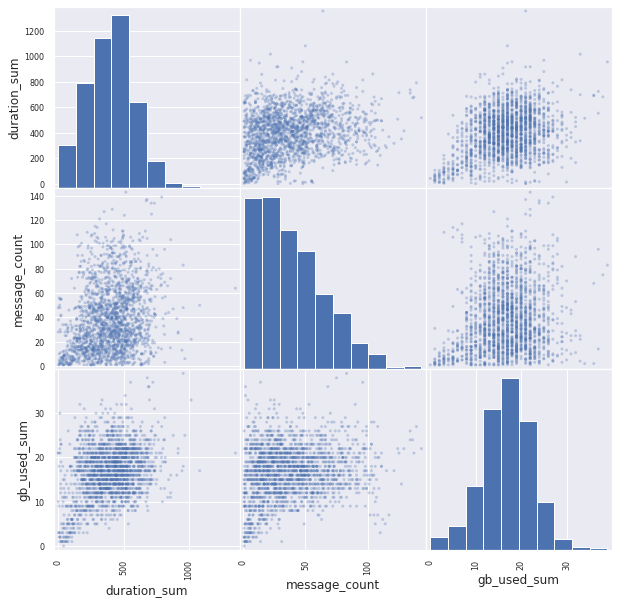

In [30]:
pd.plotting.scatter_matrix(smart[['duration_sum', 'message_count', 'gb_used_sum']], alpha = 0.3, figsize = (10,10))
plt.show( )

We have: the distribution of used gigabytes and minutes are normal, the sent messages have a Poisson distribution.

In [31]:
smart[['duration_sum', 'message_count', 'gb_used_sum']].describe()

,duration_sum,message_count,gb_used_sum
count,"1,915.00","1,915.00","1,915.00"
mean,397.36,38.77,16.73
std,177.55,26.81,5.80
min,0.00,1.00,0.00
25%,269.57,17.00,13.00
50%,403.18,34.00,17.00
75%,516.70,55.00,21.00
max,"1,354.22",143.00,39.00


#### Subtotal:

Thus, the call limit is exceeded by an average of 30 minutes (it costs about 90 rubles over the tariff), which is not so much, but the excess happens quite often (in 30% of cases). At the same time, in general, the proposed standards are sufficient for smart tariff customers - the median consumption of minutes is about 403, which does not cover the limit of 500 minutes, while the distribution of the indicator is normal. A similar situation with sent messages is the median consumption of SMS - 34 pieces per month, while the graph has the form of a Poisson distribution, which indicates that the number of clients exceeding the limit is insignificant. On average, the message limit is exceeded by only 6 pieces. With the Internet, the situation is completely different: more than 50% of customers do not fit into the traffic limit. At the same time, on average, the traffic limit is exceeded by 3 gigabytes, which is a lot, taking into account the price of 200 rubles for each gigabyte in excess. The chart below shows the situation in more detail.

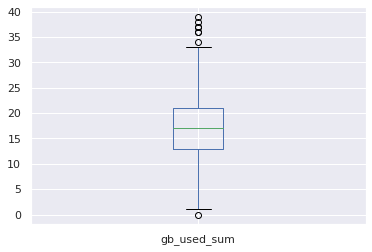

In [32]:
smart.boxplot(column=['gb_used_sum'])
plt.show()

### Ultra Tariff

We will perform the same actions for the Ultra tariff.

In [33]:
pivot_ultra = ultra.pivot_table(index = ['tariff','month'], values = ['duration_sum', 'message_count', 'gb_used_sum'], aggfunc = ['mean', 'std', 'var'])
pivot_ultra

mean                                    std              \
             duration_sum gb_used_sum message_count duration_sum gb_used_sum   
tariff month                                                                   
ultra  1.00        450.18       14.57         43.43       251.37        5.32   
       2.00        378.05       15.36         37.29       313.94       11.34   
       3.00        522.24       17.64         47.80       349.72       10.93   
       4.00        471.41       17.32         45.45       255.93        8.53   
       5.00        502.43       19.46         50.04       271.17        9.65   
       6.00        469.92       18.98         50.89       294.69        8.87   
       7.00        527.27       20.64         61.29       285.00        9.67   
       8.00        498.01       19.86         58.90       293.76        9.94   
       9.00        533.09       19.90         63.54       296.05        9.05   
       10.00       544.60       20.96         70.76       301.48        9.68   
       11.00       528.79       20.21         67.24       282.65        9.79   
       12.00       604.12       22.55         72.99       304.41        9.70   

                                    var                            
             message_count duration_sum gb_used_sum message_count  
tariff month                                                       
ultra  1.00          27.66    63,186.70       28.29        765.29  
       2.00          25.69    98,558.12      128.55        660.22  
       3.00          42.74   122,306.70      119.41      1,826.67  
       4.00          37.57    65,499.48       72.82      1,411.33  
       5.00          40.70    73,532.09       93.19      1,656.72  
       6.00          41.02    86,839.30       78.73      1,682.55  
       7.00          44.18    81,223.98       93.56      1,951.47  
       8.00          43.80    86,294.44       98.78      1,918.65  
       9.00          42.15    87,645.87       81.96      1,776.79  
       10.00         48.34    90,893.17       93.69      2,337.20  
       11.00         46.59    79,890.90       95.79      2,170.37  
       12.00         47.54    92,663.36       94.05      2,260.01

In [34]:
ultra.pivot_table(index = ['tariff'], values = ['duration_sum', 'message_count', 'gb_used_sum'], aggfunc = ['mean', 'std', 'var'])

mean                                    std              \
       duration_sum gb_used_sum message_count duration_sum gb_used_sum   
tariff                                                                   
ultra        525.66       20.09         61.64       294.45        9.64   

                              var                            
       message_count duration_sum gb_used_sum message_count  
tariff                                                       
ultra          44.82    86,701.30       92.88      2,008.55

In [35]:
print('Лимит минут превышен в среднем на:', ultra['over_lim_calls'].describe()['mean'])
print('Лимит сообщений превышен в среднем на:', ultra['over_lim_sms'].describe()['mean'])
print('Лимит гигабайт превышен в среднем на:', ultra['over_lim_gb'].describe()['mean'])

Лимит минут превышен в среднем на: 0.0
Лимит сообщений превышен в среднем на: 0.0
Лимит гигабайт превышен в среднем на: 0.7779255319148937


In [36]:
print('Лимит минут превышен в {:.2%} случаев'.format(ultra[ultra['over_lim_calls'] > 0].shape[0] / ultra['over_lim_calls'].shape[0]))
print('Лимит сообщений превышен в {:.2%} случаев'.format(ultra[ultra['over_lim_sms'] > 0].shape[0] / ultra['over_lim_sms'].shape[0]))
print('Лимит гигабайт превышен в {:.2%} случаев'.format(ultra[ultra['over_lim_gb'] > 0].shape[0] / ultra['over_lim_gb'].shape[0]))

Лимит минут превышен в 0.00% случаев
Лимит сообщений превышен в 0.00% случаев
Лимит гигабайт превышен в 13.83% случаев


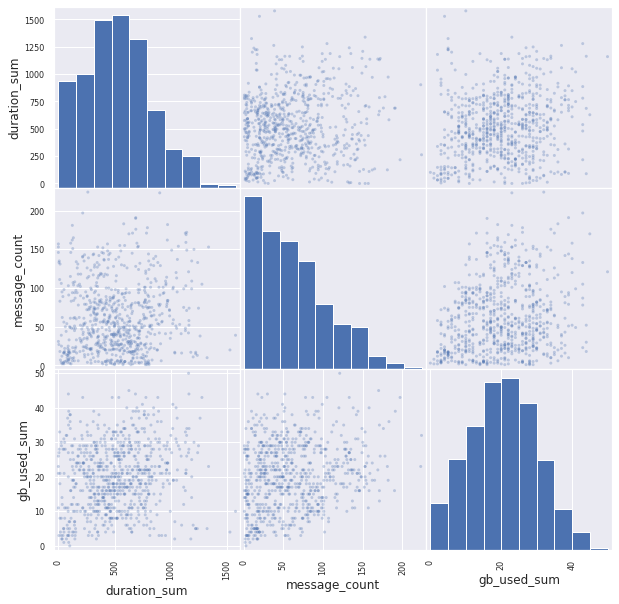

In [37]:
pd.plotting.scatter_matrix(ultra[['duration_sum', 'message_count', 'gb_used_sum']], alpha = 0.3, figsize = (10,10))
plt.show( )

We have: the distribution of used gigabytes is normal, sent messages have a Poisson distribution, used minutes distribution is normal (however tilted to the left).

In [38]:
ultra[['duration_sum', 'message_count', 'gb_used_sum']].describe()

,duration_sum,message_count,gb_used_sum
count,752.00,752.00,752.00
mean,525.66,61.64,20.09
std,294.45,44.82,9.64
min,0.00,1.00,0.00
25%,314.62,25.00,12.00
50%,506.11,53.00,20.00
75%,717.73,89.00,27.00
max,"1,578.06",224.00,50.00


#### Subtotal:

The Ultra tariff meets the needs of customers. The limit of minutes and messages is absolutely (!) not exceeded. The traffic limit was exceeded in only 14% of cases and by only 1 GB (rounded) on average.

### Conclusion:

The Ultra plan looks like a perfect fit for customers using it. Perhaps this is due to the fact that it was formed with a margin. The Smart tariff is subject to adjustment. Especially in matters relating to traffic limits. It may be necessary to raise gigabyte limits or lower the cost of gigabytes above the plan if you need to increase customer loyalty, or increase the number of gigabytes and the cost of the tariff plan at the same time to normalize the situation.

## Testing hypotheses

### Do the average revenues of Ultra and Smart tariff users differ?

In [39]:
df.pivot_table(index='tariff', values='overall_income', aggfunc=['median', 'var', 'std'])

,median,var,std
,overall_income,overall_income,overall_income
tariff,,,
smart,1051,"709,367.48",842.24
ultra,1950,"135,656.53",368.32


In this case, the hypothesis about the equality of the average revenue of users of the "Ultra" and "Smart" tariffs will be considered null. An alternative hypothesis would talk about their difference. The ttest_ind method will be used for two independent values ​​with a critical significance level alpha = 0.01 for the highest accuracy. The samples variances are different.

In [40]:
ultra_p = df.query('tariff == "ultra"')['overall_income']
smart_p = df.query('tariff == "smart"')['overall_income']

alpha = 0.01

results = st.ttest_ind(ultra_p, smart_p, equal_var=False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 7.760739607519504e-191
Отвергаем нулевую гипотезу


#### Conclusion:

So the revenue for the two tariffs is really different. The median also differs significantly. The chart below shows that smart tariff customers are likely to significantly overpay in excess of the tariff plan by the end of the month.

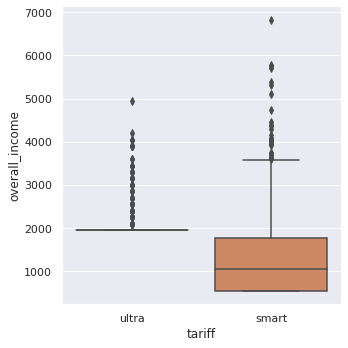

In [41]:
_ = sns.catplot(x="tariff", y='overall_income', kind="box", data=df, orient='v')

### Does the average revenue of users from Moscow differ from that of users from other regions?

In [42]:
df.pivot_table(index='region', values='overall_income', aggfunc=['median', 'var', 'std'])

,median,var,std
,overall_income,overall_income,overall_income
region,,,
Иной регион,"1,554.50","671,193.99",819.26
Москва,"1,925.00","620,132.42",787.48


In this case, the null hypothesis will be the hypothesis that the revenue received from a user from Moscow is equal to the revenue received from users from other regions. An alternative hypothesis would say that the profits are different, up or down relative to Moscow. Will use ttest_ind with equal_var=False, variance is different. The critical level of significance is at the same level (alpha = 0.01).

In [43]:
moscow = df.query('region == "Москва"')['overall_income']
other = df.query('region == "Иной регион"')['overall_income']

In [44]:
alpha = 0.01

results = st.ttest_ind(moscow, other, equal_var=False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.09297211823137636
Не получилось отвергнуть нулевую гипотезу


#### Conclusion:

Apparently, we cannot reject the null hypothesis of the equality of profit received from a resident of Moscow and profit received from a resident of another region. The probability of being mistaken in saying that the profits are different is too great. The chart below also shows that profits are about the same.

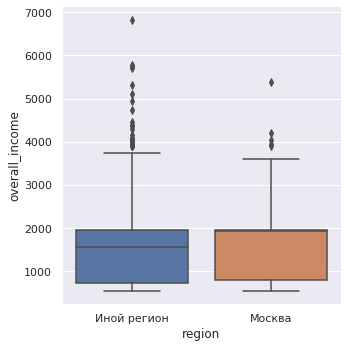

In [45]:
_ = sns.catplot(x="region", y='overall_income', kind="box", data=df, orient='v')

##  General conclusion:

A large amount of information collected from various sources was processed. The data was pre-processed: the information relating to the dates was converted into a format convenient for calculations, it was decided not to make significant changes to the data, since, in general, the information needed for the study was in a digestible state. The exceeded limits of minutes, messages and traffic for users of different tariffs by months and in general were calculated, the amounts paid by customers in excess of the tariff fee and in the amount with the tariff fee were calculated. The behavior of users of various tariffs was analyzed: it turned out that users of the Smart tariff are sorely lacking in Internet traffic, which can cause dissatisfaction, due to the high cost of a gigabyte in excess of the tariff plan. Messages and minutes in the Smart tariff package are also often not enough. Users of the Ultra tariff, on the contrary, are not able to use up the package for a month, not a single person from the sample spent minutes and messages to the end, the situation with the Internet is slightly worse - users in particular cases can use up the entire package, but the problem is not of a systemic nature, while on average Ultra plan users spend less than 1 gigabyte over the plan. The hypothesis about the equality of the amounts paid by users of both tariffs was investigated: it turned out that users of the Smart tariff are likely to significantly overpay. The hypothesis was not confirmed. The hypothesis about the equality of income received from users from Moscow and from users from other regions was also investigated. This hypothesis cannot be rejected - most likely the amounts paid by residents of the capital and regions are equal.